### Project Outline

* Read data and create subset for ones that don't have VIAF ID. 
    * We might work with the entire dataset though, because more data might make clustering names easier.
* Create 3 new columns: `parsedName`, `_personID`, `regularizedName`
    * The leading underscore indicates `personId` is a temporary column. The ID can just be a sequential integer as long as it's unique - it doesn't need to be a true hash.
    * Whether we can reliably create a `regularizedName` - i.e. a modern regular version that should replace all variations in the metadata remains to be seen. It might not be possible without a lot of human intervention. 
* We need the following functions:
    * `name_preprocess()`: Returns a cleaned up version of the name string or `None` if it doesn't look like a name.
    * `substitution_cost()`: Needed for `weighted_levenshteain()`
    * `substitution_cost_dict_generate()`: generate a cost dict for `weighted_levenshtein()`
    * `weighted_levenshtein()`
    * `name_pair()`: take a pair of preprocessed names and return a `true` if they are a close enough match that we should compute `weighted_levenshtein()` or `false` if we should ignore them. 
    * `ner_pubStmt()`: Takes the `pubStmt()` field and runs NER with `Spacy` on it.
* Procedure:
    * For each row, run `name_preprocess()`. 
        * If we get a name back, we store it in `parsedName`
    * After we are done with the entire DataFrame, take the subset that has `parsedName` set.
        * The other rows get written out to a CSV (without the 3 new columns -- these need to be run through NER and/or checked by hand)
    * In the new subset DataFrame, we generate combinations of pd.Dataframe `index` ids to generate all possible name pairs. Then run them through `name_pair()`.
    * If they pass, we run them through `weighted_levenshtein()` and store the result in a `networkx` graph where the nodes are pd.Dataframe `id` and the edges are 1/weigthed_levenshtein() \[i.e. the more similar the nodes, the higher the weight\]. If the `weighted_levenshtein()` score is above a certain threshold, we don't add it to the graph. 
    * When we are done, we break down the graph into discrete subgraphs using [this approach](https://stackoverflow.com/questions/61536745/how-to-separate-an-unconnected-networkx-graph-into-multiple-mutually-disjoint-gr). Each subgraph will be one name in all its variant forms. This performs the clustering for us. 
    * We sort these graphs by number of nodes and assign each of them a unique ID starting at 1 and then write everythin out to a CSV.

In [1]:
# Set up all imports and logging
import itertools, json, logging, re, string, sys
from collections import defaultdict

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from strsimpy.weighted_levenshtein import WeightedLevenshtein

for handler in logging.root.handlers[:]:
    logging.root.removeHandler(handler)

sh = logging.StreamHandler(sys.stderr)
sh.setLevel(logging.INFO)
fmt = '%(asctime)s %(message)s'
dfmt = '%y-%m-%d  %H:%M:%S'
logging.basicConfig(handlers=(sh,), format=fmt, datefmt=dfmt, level=logging.INFO)

##### All adjustable parameters are set here

In [46]:
printers_data_file = 'data/printers_etc.csv'
name_abbreviations_file ='./data/name_abbreviations.json'

n_test = 1000    # Subset of data for tests. Set to 0 or more than the total datasize to use everything.
records_with_viaf = False    # Whether we eliminate items that already have a resolved VIAF ID

# Change these values to zoom in on shorter yearspans in the visualization
start_year = 1400
end_year = 1750
records_within_datespan = True # If this is set, only the above datespan is kept

# This needs to have both (c1, c2) and (c2, c1) pairs only if the weights are different. 
# Otherwise (c2, c1) etc is generated automatically below.
substitution_cost_dict = {('i', 'j'): 0.3,
                          ('u', 'v'): 0.3,
                          ('y', 'i'): 0.3,
                          ('e', 'y'):.8}

##### Read external files and visualize raw data

/usr/local/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (7,11,12) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Total Number of texts:  80,153
Texts with VIAF IDs:    15,927
Texts without VIAF IDs: 64,226


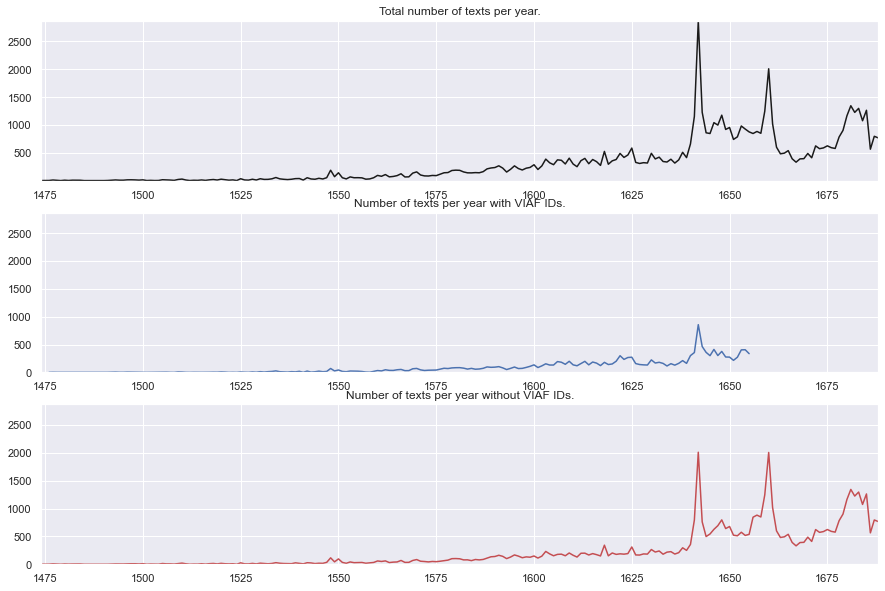

In [47]:
# The name abbreviations dictionary can be passed to the name_preprocess function
with open(name_abbreviations_file) as file:
    name_abbreviations = json.load(file)

printers_df = pd.read_csv(printers_data_file)

# This is necessary because some parsedDates have two years (this needs to be fixed)
# So we just keep the first year and then turn the whole column to ints
printers_df['parsedDate'] = printers_df['parsedDate'].str[:4]
printers_df['parsedDate'] = pd.to_numeric(printers_df['parsedDate'])

viaf_exists = printers_df[~printers_df['viafId'].isna()]
viaf_needed = printers_df[printers_df['viafId'].isna()]

total_counts = printers_df.groupby(['parsedDate'])['parsedDate'].count()
viaf_exists_counts = viaf_exists.groupby(['parsedDate'])['parsedDate'].count()
viaf_needed_counts = viaf_needed.groupby(['parsedDate'])['parsedDate'].count()

# Set up the plot
sns.set_theme(style="darkgrid")
fig = plt.figure(figsize=(15,10))
grid = plt.GridSpec(3,1)
axes = [fig.add_subplot(grid[0, 0]), fig.add_subplot(grid[1, 0]), fig.add_subplot(grid[2, 0])]

sns.lineplot(data=total_counts, x=total_counts.index, y=total_counts.values, color='k', ax=axes[0])
sns.lineplot(data=viaf_exists_counts, x=viaf_exists_counts.index, y=viaf_exists_counts.values, color='b', ax=axes[1])
sns.lineplot(data=viaf_needed_counts, x=viaf_needed_counts.index, y=viaf_needed_counts.values, color='r', ax=axes[2])

start_year = start_year if int(total_counts.index[0]) < start_year else int(total_counts.index[0])
end_year = end_year if int(total_counts.index[-1]) > end_year else int(total_counts.index[-1])
axes[0].set(xlim=(start_year, end_year), ylim=(1, max(total_counts[start_year:end_year].values+1)), xlabel=None, title='Total number of texts per year.')
axes[1].set(xlim=(start_year, end_year), ylim=(0, max(total_counts[start_year:end_year].values)+1), xlabel=None, title='Number of texts per year with VIAF IDs.')
axes[2].set(xlim=(start_year, end_year), ylim=(0, max(total_counts[start_year:end_year].values)+1), xlabel=None, title='Number of texts per year without VIAF IDs.')

print('Total Number of texts:  {:,}\nTexts with VIAF IDs:    {:,}\nTexts without VIAF IDs: {:,}'\
          .format(len(printers_df), len(viaf_exists), len(viaf_needed)))

In [40]:
# slice data to produce the final dataframe we'll work on
if records_with_viaf:
    df = printers_df
    logging.info('Including records with assigned VIAF IDs')
else:
    df = viaf_needed
    logging.info('Excluding records with assigned VIAF IDs')

if records_within_datespan:
    df = df[(df['parsedDate']>=start_year) & (df['parsedDate']<=end_year)]
    logging.info(f'Keeping records within {start_year} and {end_year}')
    
if n_test==0:
    df = df
    logging.info(f'Keeping all {len(df)} records')
else:
    df = df[:n_test]
    logging.info(f'Keeping the first {len(df)} records')

23-02-27  00:50:29 Including records with assigned VIAF IDs
23-02-27  00:50:29 Keeping records within 1474 and 1478
23-02-27  00:50:29 Keeping the first 15 records


In [75]:
def name_preprocess(full_name, lower_case=True, title_case=True, \
                    name_abbreviations=name_abbreviations, \
                    max_length=30, min_tokens=2, max_tokens=4):
    """
    Returns a cleaned up version of the name string or None if it doesn't look like a name.
    
    We remove any preceding 'me', clean up punctuation, extra spaces. Throw out 
    names that are too long or have too few or too many tokens. Substitute vv -> w.
    Also expand name abbreviations. Lower and Title case options available. Titlecase
    takes precedence.
    """
    full_name = re.sub(f'^me\s*|[{string.punctuation}]|\d*', '', full_name)
    # Collapse vv to w
    full_name = re.sub('vv', 'w', full_name)
    full_name = re.sub('VV', 'W', full_name)
    if lower_case:
        full_name = full_name.lower()
    
    #ignore names that are too long
    if len(full_name) > max_length:
        logging.info(f'Too long: Ignoring: {full_name}')
        return None
    #find all strings separated by whitespace
    words = re.findall(r'\b\w+\b', full_name)
    # check if the number of words is at least 2 or over 4
    if len(words) < min_tokens:
        logging.info(f'Too few tokens: Ignoring: {full_name}')
        return None
    if len(words) > max_tokens:
        logging.info(f'Too many tokens: Ignoring: {full_name}')
        return None
    # return the first word and remaining string as a tuple
    first_name = words[0]
    if first_name in name_abbreviations:
        first_name = name_abbreviations[first_name]
    last_name = ' '.join(words[1:])
    if title_case:
        first_name = first_name.title()
        last_name = last_name.title()
    return (first_name, last_name)

def substitution_cost(x, y, substitution_cost_dict=substitution_cost_dict):
    """
    Takes a pair of letters and returns a substitution cost for them
    """
    sc = substitution_cost_dict[(x,y)] if (x, y) in substitution_cost_dict else 1.0
    return sc

def substitution_cost_dict_generate(substitution_cost_dict, swapcase_weight=0.2):
    """
    Generate reverse pairs for the cost dictionary. I.e. is ('u', 'v') is supplied,
    generate ('v', 'u'). ('u', 'V') and ('U', 'v') are also generated. Other letters 
    get the swapcase weight. So the cost of 'A'->'a' is swapcase_weight. This can be 
    set to zero, if you don't care about swapping cases.
    """
    reversed_substitution_cost_dict = {}

    for (c1, c2), w in substitution_cost_dict.items():
        # (i, j) -> (j, i)
        if (c2, c1) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c2, c1)] = w
        # (i, j) -> (i, J) and (I, j)
        if (c1.swapcase(), c2) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1.swapcase(), c2)] = w
        if (c1, c2.swapcase()) not in substitution_cost_dict:
            reversed_substitution_cost_dict[(c1, c2.swapcase())] = w
        # (a, A), (A, a) etc
        for l in string.ascii_letters:
            if (l, l.swapcase()) not in substitution_cost_dict:
                reversed_substitution_cost_dict[(l, l.swapcase())] = swapcase_weight

    substitution_cost_dict = {**substitution_cost_dict, **reversed_substitution_cost_dict}

    return substitution_cost_dict

def name_pair(n1, n2, letter_similarity_threshold=.5):
    """
    This is a prescreening function to judge if a pair of names is viable for a match
    with weighted levenshtein. We can set up various criteria for a possible match.
    
    If names have same or similar initials. 
    Not implemented yet: If they share a substantial portion of their letters.
    """
    f1, l1 = n1
    f2, l2 = n2
    
    # Do they have same or similar initials
    if (((f1[0]==f2[0]) or (substitution_cost(f1[0], f2[0])<letter_similarity_threshold)) and \
                      ((l1[0]==l2[0]) or (substitution_cost(l1[0], l2[0])<letter_similarity_threshold))):
        return True
    return False